In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.utils as vutils

In [ ]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type=int, default=200)
parser.add_argument("--batch_size", type=int, default=64)
parser.add_argument("--lr", type=float, default=2e-4)
parser.add_argument("--nch_g", type=int, default=128)
parser.add_argument("--nch_d", type=int, default=128)
parser.add_argument("--z_dim", type=int, default=100)
parser.add_argument("--beta1", type=float, default=0.5)
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=64, beta1=0.5, lr=0.0002, n_epoch=200, nch_d=128, nch_g=128, z_dim=100)


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, ngf=128, nc=1):
        super().__init__()
        self.convt1 = self.conv_trans_layers(z_dim, 4 * ngf, 3, 1, 0)
        self.convt2 = self.conv_trans_layers(4 * ngf, 2 * ngf, 3, 2, 0)
        self.convt3 = self.conv_trans_layers(2 * ngf, ngf, 4, 2, 1)
        self.convt4 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            nn.Tanh()
        )


    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding):
        net = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, 
                               stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return net
    
    def forward(self, x):
        out = self.convt1(x)
        out = self.convt2(out)
        out = self.convt3(out)
        out = self.convt4(out)
        return out

In [ ]:
x = torch.randn([32, 100, 1, 1])
netG = Generator(z_dim=opt.z_dim, ngf=opt.nch_g)
out = netG(x)

In [ ]:
out.size()

torch.Size([32, 1, 28, 28])

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=128):
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf, has_batch_norm=False)
        self.conv2 = self.conv_layers(ndf, 2 * ndf)
        self.conv3 = self.conv_layers(2 * ndf, 4 * ndf, 3, 2, 0)
        self.conv4 = nn.Sequential(
            nn.Conv2d(4 * ndf, 1, 3, 1, 0),
            nn.Sigmoid()
        )

    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1,
                    has_batch_norm=True):
        layers = [
                  nn.Conv2d(in_channels, out_channels, kernel_size, stride,
                            padding, bias=False)
        ]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        net = nn.Sequential(*layers)
        return net
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        return out

In [ ]:
x = torch.randn(32, 1, 28, 28)
netD = Discriminator(nc=1, ndf=opt.nch_d)
out = netD(x)

In [ ]:
out.size()

torch.Size([32, 1, 1, 1])

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))                               
])

In [ ]:
import os

In [ ]:
dir_path = "./drive/MyDrive/result"
os.makedirs(dir_path, exist_ok=True)

In [ ]:
dataset = dset.MNIST(root="./drive/MyDrive/data/", download=False,
                     train=True, transform=transform)
dataloader = DataLoader(dataset=dataset, batch_size=opt.batch_size,shuffle=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
netG = Generator(z_dim=opt.z_dim, ngf=opt.nch_g).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(nc=1, ndf=opt.nch_d).to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt4): Sequential(
    (0): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
  )
)
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=

In [ ]:
criterion = nn.BCELoss()

optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999), weight_decay=1e-5)
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999), weight_decay=1e-5)

In [ ]:
def save_params(file_path, epoch, netD, netG):
    torch.save(
        netG.state_dict(),
        file_path + "/g_{:04d}.pth".format(epoch)
    )

    torch.save(
        netD.state_dict(),
        file_path + "/d_{:04d}.pth".format(epoch)
    )


In [ ]:
model_name = "DCGAN"
f_path_result = "./drive/MyDrive/result/{}".format(model_name)
f_path_params = "./drive/MyDrive/params/{}".format(model_name)

os.makedirs(f_path_result, exist_ok=True)
os.makedirs(f_path_params, exist_ok=True)

100%|██████████| 938/938 [00:57<00:00, 16.19it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0, lossD: 0.583857335801572, lossG: 2.3927713253303


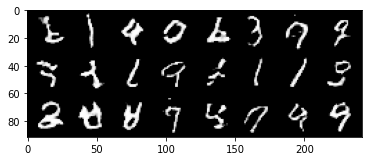

100%|██████████| 938/938 [00:57<00:00, 16.41it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1, lossD: 0.6435022488045794, lossG: 2.327446367345385


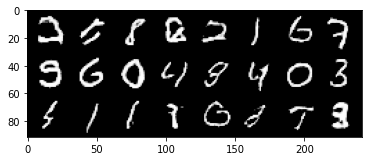

100%|██████████| 938/938 [00:57<00:00, 16.37it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2, lossD: 0.6230459155431435, lossG: 2.3949178242480067


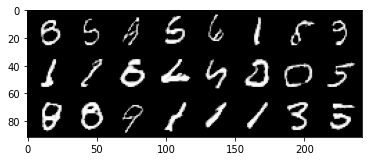

100%|██████████| 938/938 [00:57<00:00, 16.40it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3, lossD: 0.6337136150613777, lossG: 2.423102201079763


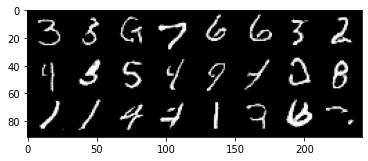

100%|██████████| 938/938 [00:57<00:00, 16.39it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4, lossD: 0.6350185756267769, lossG: 2.4812255858707783


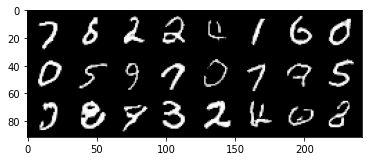

100%|██████████| 938/938 [00:57<00:00, 16.36it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 5, lossD: 0.5863691278929903, lossG: 2.58480242501571


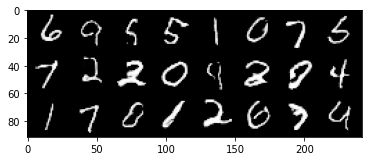

100%|██████████| 938/938 [00:57<00:00, 16.32it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 6, lossD: 0.5753076172459608, lossG: 2.6685243912660743


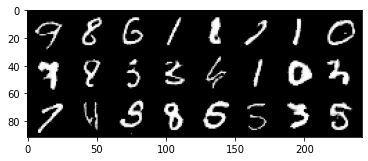

100%|██████████| 938/938 [00:57<00:00, 16.35it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 7, lossD: 0.5417159207181127, lossG: 2.7335771295243996


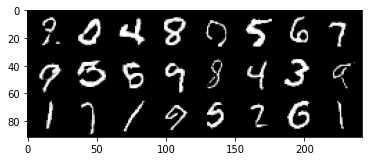

100%|██████████| 938/938 [00:57<00:00, 16.35it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 8, lossD: 0.5352948611892109, lossG: 2.826778423144365


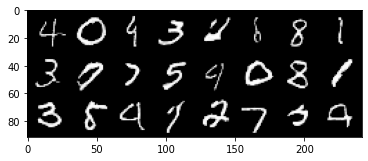

100%|██████████| 938/938 [00:57<00:00, 16.31it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 9, lossD: 0.5419838644389404, lossG: 2.840680838639993


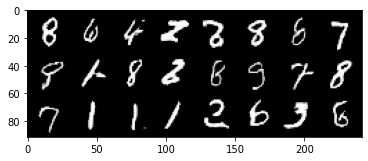

100%|██████████| 938/938 [00:57<00:00, 16.22it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 10, lossD: 0.4854141743833831, lossG: 2.996650679422213


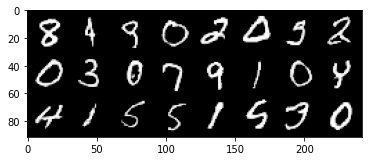

100%|██████████| 938/938 [00:57<00:00, 16.22it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 11, lossD: 0.4941956722247067, lossG: 3.007955782655587


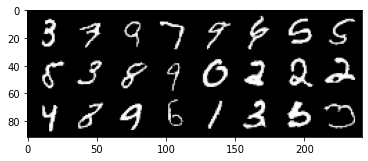

100%|██████████| 938/938 [00:57<00:00, 16.19it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 12, lossD: 0.45038861173715417, lossG: 3.115754049438149


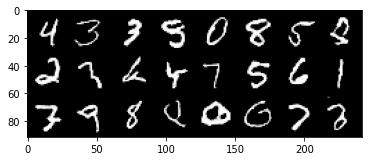

100%|██████████| 938/938 [00:57<00:00, 16.22it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 13, lossD: 0.4672458780361518, lossG: 3.1327734911429093


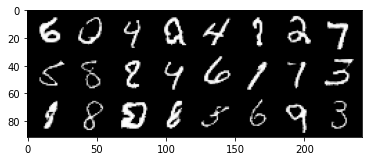

100%|██████████| 938/938 [00:57<00:00, 16.20it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 14, lossD: 0.4569450068527829, lossG: 3.20286733736155


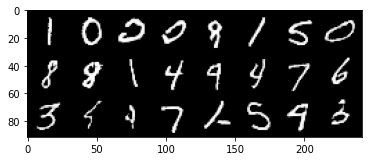

100%|██████████| 938/938 [00:58<00:00, 16.17it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 15, lossD: 0.44195148269377793, lossG: 3.2799625042627363


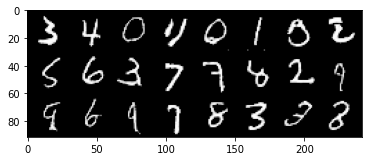

100%|██████████| 938/938 [00:57<00:00, 16.24it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 16, lossD: 0.4310868733139562, lossG: 3.289620046327109


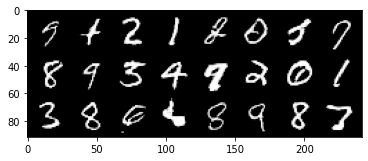

100%|██████████| 938/938 [00:57<00:00, 16.19it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 17, lossD: 0.4181230904768779, lossG: 3.353899847700207


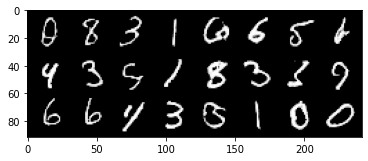

100%|██████████| 938/938 [00:58<00:00, 16.17it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 18, lossD: 0.43729345113642687, lossG: 3.3685116617918522


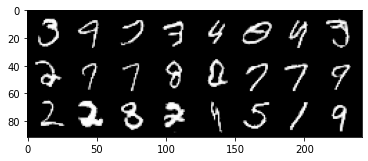

100%|██████████| 938/938 [00:58<00:00, 15.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 19, lossD: 0.4009782931824991, lossG: 3.4499603763564246


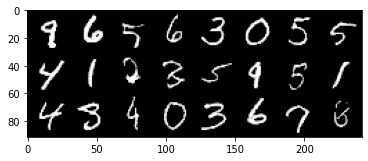

100%|██████████| 938/938 [00:58<00:00, 15.93it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 20, lossD: 0.41766003732170376, lossG: 3.438781610811189


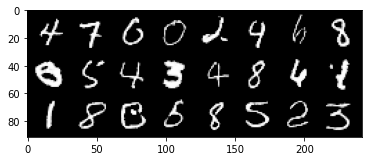

100%|██████████| 938/938 [00:58<00:00, 16.00it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 21, lossD: 0.42954609003752026, lossG: 3.4581758526247195


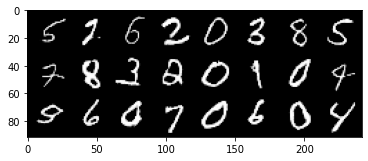

100%|██████████| 938/938 [00:58<00:00, 16.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 22, lossD: 0.3839277089801806, lossG: 3.603875704602138


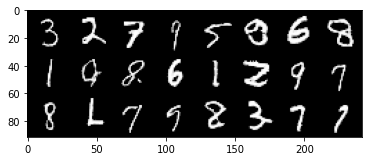

100%|██████████| 938/938 [00:58<00:00, 16.09it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 23, lossD: 0.38094900221998756, lossG: 3.5716935246865122


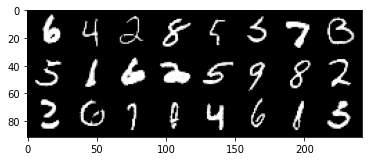

 96%|█████████▌| 900/938 [00:55<00:02, 15.98it/s]

KeyboardInterrupt: ignored

In [ ]:
lossesD = []
lossesG = []
raw_lossesD = []
raw_lossesG = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0
    running_lossG = 0.0
    for i, (real_imgs, labels) in enumerate(tqdm.tqdm(dataloader, position=0)):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        shape = (batch_size, 1, 1, 1)
        labels_real = torch.ones(shape).to(device)
        labels_fake = torch.zeros(shape).to(device)
        #
        # train Discriminator
        #
        netD.zero_grad()
        output = netD(real_imgs)
        lossD_real = criterion(output, labels_real)

        fake_imgs = netG(noise)
        output = netD(fake_imgs.detach())
        lossD_fake = criterion(output, labels_fake)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()
        #
        # train Generator
        #
        netG.zero_grad()
        output = netD(fake_imgs)
        lossG = criterion(output, labels_real)
        lossG.backward()
        optimizerG.step()
        #
        # save losses
        #
        running_lossD += lossD.item()
        running_lossG += lossG.item()
        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())
    running_lossD /= len(dataloader)
    running_lossG /= len(dataloader)
    print("epoch: {}, lossD: {}, lossG: {}".format(epoch, running_lossD, running_lossG))
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)
    #
    # show fake imgs
    #
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach())
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1, 2, 0)))
    plt.show()
    #
    # save imgs & parameters
    #
    vutils.save_image(fake_imgs, f_path_result + "/{}.jpg".format(epoch))
    save_params(f_path_params, epoch, netD, netG)

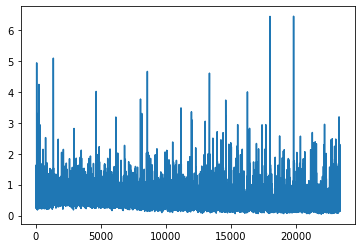

In [ ]:
plt.plot(raw_lossesD)

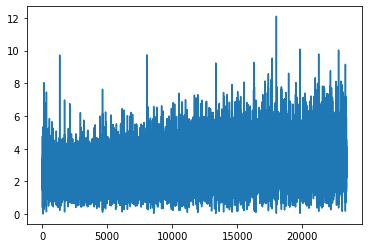

In [ ]:
plt.plot(raw_lossesG)

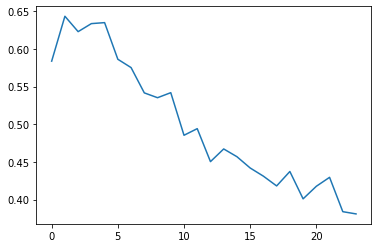

In [ ]:
plt.plot(lossesD)

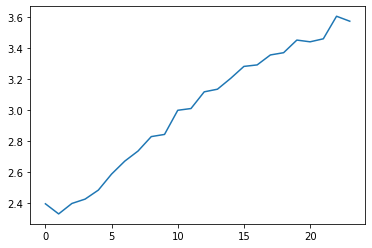

In [ ]:
plt.plot(lossesG)